In [1]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from scipy.stats import linregress

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/prubbens/.local/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Import the dataframes: 

In [2]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/1seq_in_3samples/nochloro_absolute_otu_1seqin3samps.tsv', sep=' ', index_col=None, header=0, float_precision='high')
data_rel = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/1seq_in_3samples/nochloro_relative_1seqin3samps.tsv', sep=' ', index_col=None, header=0, float_precision='high')
target = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/1seq_in_3samples/nochloro_HNA_LNA_1seqin3samps.tsv', sep= ' ', index_col=0, header=0)

**2)**: At 01-05-'17 @marschmi found that a few samples can be seen as outliers, as they represent the bottom waters of productive inland lakes, resulting in a big difference of the HNA percentage. These samples are the following: Z14055F, Z14003F, Z14007F, Z14023F, Z14011F. A code of line is added, in order to be able to run the pipeline without these samples; 

In [3]:
#samples_to_drop = ['Z14055F', 'Z14003F', 'Z14007F', 'Z14023F', 'Z14011F']
#index = target.index.drop(samples_to_drop)

In [4]:
'''Set sample names as index and shuffle data'''
index = data_rel.index

#Remove outlier samples:
data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
#productivity = productivity.loc[index,:]

#Shuffle data: 
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
#productivity = productivity.sample(frac=1, random_state=3) 

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[:,'LNA.cells']
lna_rel = lna/target.loc[:,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

In [5]:
#Some variables to store information and to create inner and outer CV-folds

data_rel = data_rel.loc[:, (data_rel != 0).any(axis=0)]
otus = list(data_rel.columns)

#cv_out = 10
cv = 5
#outer_cv = KFold(n_splits=cv_out, shuffle=False)

#otu_scores_cv = pd.DataFrame(columns=otus)
#r2_cv = np.zeros(cv_out)
#thresholds_cv = np.zeros(cv_out)

#pred = pd.Series(index=data_abs.index)
#final_scores = pd.DataFrame(columns=otus)

#thresholds = np.arange(0,1,0.01)
#t = 0

In [6]:
''' Standardize data '''
from analysis_functions import standardize_df
data_stand, scaler = standardize_df(data_rel,otus)

To do so, we use the **_Randomized Lasso_**: this method makes use of two kinds of randomization in order to select variables (i.e., OTU's) with a certain _stability_: (1) it fits a Lasso to various bootstrap subsamples and (2) it perturbs the initial weighting of certain variables. 

This results in a $score \in [0,1]$ that is assigned to variables, with 0 denoting the case where a variable is never chosen by the Lasso, and 1 denoting the case where a variable always is chosen. In other words, the higher the score, the more important a variable can be considered to be. 

**First goal: ** try to pinpoint those OTU's for which we are sure they are present in the '_HNA-cloud_'. 

**Univariate Feature Selection**: 

Let's compare two methods: 
- f_regression (f-score pearson correlation), 
- Mutual information,  
- (other methods can follow as well). 

In [7]:
f_regr, f_regr_p = f_regression(data_stand.loc[:,otus],hna)
uni_fs = pd.DataFrame(f_regr, index=otus, columns = ['f_regr'])
uni_fs['p-value'] = f_regr_p
uni_fs['mi'] = mutual_info_regression(data_stand.loc[:,otus],hna)
uni_fs.sort_values(ascending=False,inplace=True, by='f_regr')
display(uni_fs.head(10))

,f_regr,p-value,mi
Otu000060,113.782688,1.464712e-20,0.305275
Otu000173,101.698447,5.910719e-19,0.347162
Otu000001,92.593481,1.075090e-17,0.347498
Otu000187,60.546033,7.276621e-13,0.200173
Otu000335,51.622804,2.163799e-11,0.266137
Otu000222,50.335527,3.573317e-11,0.185724
Otu000027,47.982644,9.013674e-11,0.186330
Otu000271,40.766557,1.651833e-09,0.377648
Otu000326,40.752667,1.661284e-09,0.334526
Otu000038,39.756370,2.504108e-09,0.297200


Select otu's based on $p < \text{thr}$: 

In [8]:
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p-value'].values < 0.05]
print('Number of selected OTUs with p < 0.05: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p-value'].values < 0.01]
print('Number of selected OTUs with p < 0.01: ' + str(len(uni_fs_selected_f)))

Number of selected OTUs with p < 0.05: 690
Number of selected OTUs with p < 0.01: 361


What happens when we tune a threshold in function of the f_score: 

In [9]:
from analysis_functions import get_r2_scores
thr_otu_f_regr_hna, r2_otu_f_regr_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs['f_regr'], cv)
thr_otu_f_regr_lna, r2_otu_f_regr_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs['f_regr'], cv)

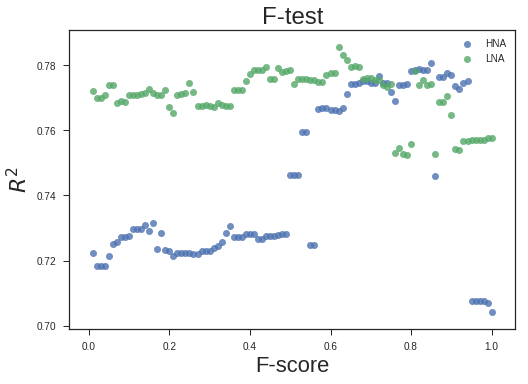

In [10]:
plt.figure()
sns.regplot(x=thr_otu_f_regr_hna,y=r2_otu_f_regr_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_f_regr_lna,y=r2_otu_f_regr_lna, fit_reg=False, label='LNA')
plt.xlabel('F-score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('F-test', size=24)
plt.legend()
plt.show()

In [11]:
#uni_fs.sort_values(ascending=False,inplace=True, by='mi')
#display(uni_fs.head(10))
#thr_otu_mi_hna, r2_otu_mi_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs['mi'], cv)
#thr_otu_mi_lna, r2_otu_mi_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs['mi'], cv)

In [12]:
#plt.figure()
#sns.regplot(x=thr_otu_mi_hna,y=r2_otu_mi_hna, fit_reg=False, label='HNA')
#sns.regplot(x=thr_otu_mi_lna,y=r2_otu_mi_lna, fit_reg=False, label='LNA')
#plt.xlabel('MI', size=22)
#plt.xticks(size=10)
#plt.ylabel(r'$R^2$', size=22)
#plt.yticks(size=10)
#plt.title('Mutual Information', size=24)
#plt.legend()
#plt.show()

In [13]:
from analysis_functions import get_lassoCV_alpha

alpha = get_lassoCV_alpha(data_stand.loc[:,otus],hna,otus,cv)
    
otu_scores = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], hna, alpha), index=otus, columns=['score'])
otu_scores.sort_values(ascending=False,inplace=True, by='score')

thr_otu_scores_hna, r2_otu_scores_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, otu_scores, cv)
thr_otu_scores_lna, r2_otu_scores_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, otu_scores, cv)

/home/prubbens/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/home/prubbens/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/home/prubbens/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))
/home/prubbens/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/home/prubbens/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos

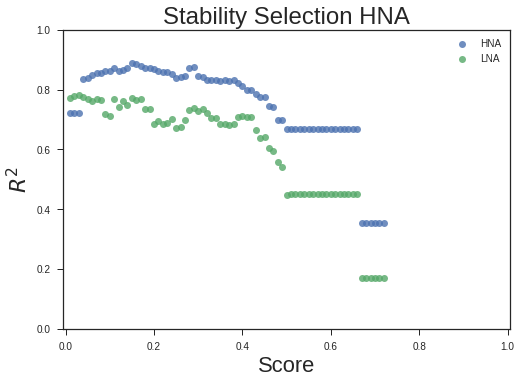

In [14]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.axis([-0.005,1.005,0,1])
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.title('Stability Selection HNA', size=24)
plt.show()

In [15]:
r2_final = r2_otu_scores_hna.max()
thr = thr_otu_scores_hna[r2_otu_scores_hna.argmax()]
print('R²_cv(hna): ' + str(r2_final) )
print('Threshold score: ' + str(thr))

R²_cv(hna): 0.888922996542
Threshold score: 0.15


In [16]:
otu_scores = otu_scores.assign(abun_abs_mean = data_abs.loc[:,otus].mean())
otu_scores = otu_scores.assign(abun_abs_CV = data_abs.loc[:,otus].std()/data_abs.loc[:,otus].mean())
otu_scores =  otu_scores.assign(abun_rel_mean = data_rel.loc[:,otus].mean())
otu_scores = otu_scores.assign(abun_rel_CV = data_rel.loc[:,otus].std()/data_rel.loc[:,otus].mean())
otu_scores.to_csv('Final/hnascores_otus_1seq3_rel.csv')

In [18]:
otu_scores_selected = otu_scores[otu_scores.score.values>thr]
selected_otus = otu_scores_selected.index
otu_scores_selected.to_csv('Final/hnascores_otus_tuned_thr_'+str(thr)+'_1seq3_rel.csv')
display(otu_scores_selected.head(10))
print('Size list selected OTUs: ' + str(len(selected_otus)))

,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV
Otu000001,0.720000,371601.089939,0.720490,0.095239,0.631085
Otu000173,0.653333,8892.157986,1.953307,0.001270,1.729254
Otu000060,0.653333,26355.897534,1.500728,0.003828,1.085250
Otu000335,0.500000,6250.999417,2.165661,0.000927,1.748611
Otu000074,0.483333,12612.177451,0.802366,0.003443,0.878576
Otu000025,0.476667,78679.771581,1.040659,0.015052,0.771797
Otu000160,0.463333,18969.044325,3.110295,0.002236,2.822739
Otu000088,0.460000,5087.595794,1.342708,0.001828,1.561502
Otu000075,0.460000,18236.076497,1.294892,0.006315,1.554322
Otu000981,0.453333,631.164361,4.614274,0.000101,4.698286


Size list selected OTUs: 187


In [19]:
print('R²_cv of HNA-selected OTUs in function of LNA: ' + str(r2_otu_scores_lna[r2_otu_scores_hna.argmax()]) )

R²_cv of HNA-selected OTUs in function of LNA: 0.773445754928


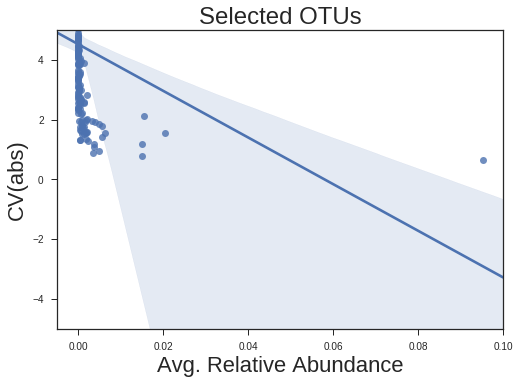

In [20]:
plt.figure()
sns.regplot(x='abun_rel_mean',y='abun_rel_CV', data=otu_scores_selected)
plt.axis([-0.005,0.1,-5,5])
plt.xlabel('Avg. Relative Abundance', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.title('Selected OTUs', size=24)
plt.show()

In [ ]:
#optimal_scores.to_csv('HNA_selectedOTUs_stand_abun_remov' + str(abun)+'_R2'+str(r2_final)+'.csv')

**Second goal**: Can we use the same pipeline to predict the _LNA_-counts? 

In [21]:
f_regr_lna, f_regr_p_lna = f_regression(data_stand.loc[:,otus],lna)
uni_fs_lna = pd.DataFrame(f_regr_lna, index=otus, columns = ['f_regr'])
uni_fs_lna['p-value'] = f_regr_p_lna
uni_fs_lna['mi'] = mutual_info_regression(data_stand.loc[:,otus],lna)
uni_fs_lna.sort_values(ascending=False,inplace=True, by='f_regr')
display(uni_fs_lna.head(10))

,f_regr,p-value,mi
Otu000060,125.918078,4.195494e-22,0.419967
Otu000027,114.672122,1.122970e-20,0.586643
Otu000043,69.272216,3.015470e-14,0.438985
Otu000108,66.336430,8.677649e-14,0.359080
Otu000017,62.500856,3.526935e-13,0.278839
Otu000187,61.625072,4.874827e-13,0.192222
Otu000271,61.193653,5.720198e-13,0.277001
Otu000317,57.045340,2.706653e-12,0.191489
Otu000078,56.572494,3.237570e-12,0.368802
Otu000313,54.600811,6.862489e-12,0.163488


In [22]:
uni_fs_selected_f_lna = uni_fs_lna[uni_fs_lna.loc[:,'p-value'].values < 0.05]
print('Number of selected OTUs with p < 0.05: ' + str(len(uni_fs_selected_f_lna)))
uni_fs_selected_f_lna = uni_fs_lna[uni_fs_lna.loc[:,'p-value'].values < 0.01]
print('Number of selected OTUs with p < 0.01: ' + str(len(uni_fs_selected_f_lna)))

Number of selected OTUs with p < 0.05: 684
Number of selected OTUs with p < 0.01: 413


In [23]:
thr_otu_f_regr_lna, r2_otu_f_regr_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs_lna['f_regr'], cv)
thr_otu_f_regr_hna, r2_otu_f_regr_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs_lna['f_regr'], cv)

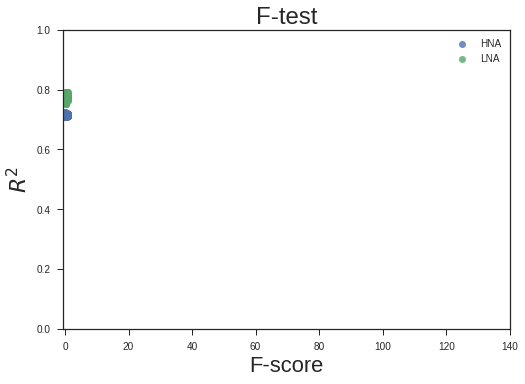

In [24]:
plt.figure()
sns.regplot(x=thr_otu_f_regr_hna,y=r2_otu_f_regr_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_f_regr_lna,y=r2_otu_f_regr_lna, fit_reg=False, label='LNA')
plt.axis([-0.5,140,0,1])
plt.xlabel('F-score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('F-test', size=24)
plt.legend()
plt.show()

In [25]:
alpha = get_lassoCV_alpha(data_stand.loc[:,otus],lna,otus,cv)
otu_scores_lna = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], lna, alpha), index=otus, columns=['score'])
otu_scores_lna.sort_values(ascending=False, inplace=True, by='score')

thr_otu_scores_lna, r2_otu_scores_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, otu_scores_lna, cv)
thr_otu_scores_hna, r2_otu_scores_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, otu_scores_lna, cv)

/home/prubbens/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/home/prubbens/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/home/prubbens/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/home/prubbens/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))
/home/prubbens/.local/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos

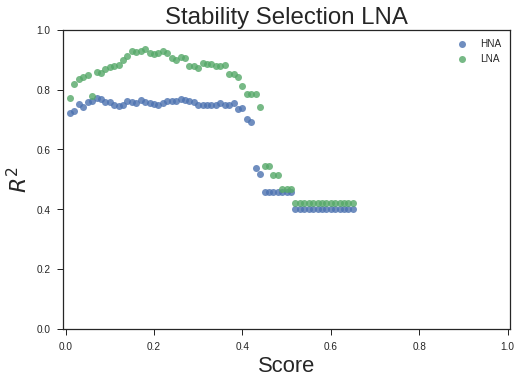

In [26]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.axis([-0.005,1.005,0,1])
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.title('Stability Selection LNA', size=24)
plt.show()

In [27]:
r2_final = r2_otu_scores_lna.max()
thr_lna = thr_otu_scores_lna[r2_otu_scores_lna.argmax()]
print('R²_cv(lna): ' + str(r2_final) )
print('Threshold score: ' + str(thr_lna))

R²_cv(lna): 0.934639051702
Threshold score: 0.18


In [28]:
otu_scores_lna = otu_scores_lna.assign(abun_abs_mean = data_abs.loc[:,otus].mean())
otu_scores_lna = otu_scores_lna.assign(abun_abs_CV = data_abs.loc[:,otus].std()/data_abs.loc[:,otus].mean())
otu_scores_lna =  otu_scores_lna.assign(abun_rel_mean = data_rel.loc[:,otus].mean())
otu_scores_lna = otu_scores_lna.assign(abun_rel_CV = data_rel.loc[:,otus].std()/data_rel.loc[:,otus].mean())
otu_scores_lna.to_csv('Final/lnascores_otus_abun_1seq3_rel.csv')


In [29]:
otu_scores_selected_lna = otu_scores_lna[otu_scores_lna.score.values>thr_lna]
selected_otus_lna = otu_scores_selected_lna.index
print('Size list selected OTUs: ' + str(len(selected_otus_lna)))
otu_scores_selected_lna.to_csv('Final/lnascores_otus_tuned_thr_'+str(thr_lna)+'_1seq3_rel.csv')
display(otu_scores_selected_lna.head(10))

Size list selected OTUs: 153


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV
Otu000060,0.650000,26355.897534,1.500728,0.003828,1.085250
Otu000075,0.510000,18236.076497,1.294892,0.006315,1.554322
Otu000053,0.473333,27862.529944,1.460392,0.004684,0.981394
Otu000017,0.460000,46181.687512,1.174592,0.015009,1.172510
Otu001152,0.440000,107.638432,3.828249,0.000057,3.755027
Otu000108,0.436667,16074.992429,2.334943,0.002090,2.019788
Otu000113,0.436667,5888.695140,2.532970,0.000743,2.430206
Otu000074,0.433333,12612.177451,0.802366,0.003443,0.878576
Otu000597,0.430000,2065.701352,2.297885,0.000313,2.057057
Otu000103,0.426667,10533.594120,1.946357,0.003395,1.618194


In [30]:
print('R²_cv of LNA-selected OTUs in function of HNA: ' + str(r2_otu_scores_hna[r2_otu_scores_lna.argmax()]) )

R²_cv of LNA-selected OTUs in function of HNA: 0.759070950399


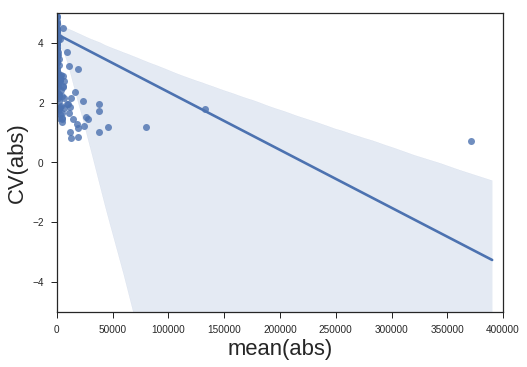

In [31]:
plt.figure()
sns.regplot(x='abun_abs_mean',y='abun_abs_CV', data=otu_scores_selected_lna)
plt.axis([0,400000,-5,5])
plt.xlabel('mean(abs)', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.show()

Let's compare the HNA- and LNA-lists, which OTU's are shared (_common_) and which are only part of the HNA- or LNA subset?: 

In [32]:
idx_hna = otu_scores_selected.index.difference(otu_scores_selected_lna.index)
idx_lna = otu_scores_selected_lna.index.difference(otu_scores_selected.index)
idx_common = otu_scores_selected.drop(idx_hna).index
pd.Series(idx_common).to_csv('commonOTU_HNALNA_abun.001_rel.csv')
print('Size subset OTUs only related to HNA: ' + str(len(idx_hna)) + '; opposed to total size: ' + str(len(otu_scores_selected)))
print('Size subset OTUs only related to LNA: ' + str(len(idx_lna)) + '; opposed to total size: ' + str(len(otu_scores_selected_lna)))
print('Size subset OTUs related to both: ' + str(len(idx_common)))

display(otu_scores_selected_lna.loc[idx_common,:])
#data_abs_raw = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
#data_abs_raw = data_abs_raw.loc[index,:]
#display(data_abs_raw.loc[:,idx_hna].sum(axis=1).values/hna.values)

Size subset OTUs only related to HNA: 113; opposed to total size: 187
Size subset OTUs only related to LNA: 79; opposed to total size: 153
Size subset OTUs related to both: 74


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV
Otu000001,0.420000,371601.089939,0.720490,0.095239,0.631085
Otu000173,0.416667,8892.157986,1.953307,0.001270,1.729254
Otu000060,0.650000,26355.897534,1.500728,0.003828,1.085250
Otu000335,0.406667,6250.999417,2.165661,0.000927,1.748611
Otu000074,0.433333,12612.177451,0.802366,0.003443,0.878576
Otu000160,0.396667,18969.044325,3.110295,0.002236,2.822739
Otu000088,0.336667,5087.595794,1.342708,0.001828,1.561502
Otu000075,0.510000,18236.076497,1.294892,0.006315,1.554322
Otu000981,0.283333,631.164361,4.614274,0.000101,4.698286
Otu000313,0.373333,2492.843861,2.222905,0.000331,1.941756


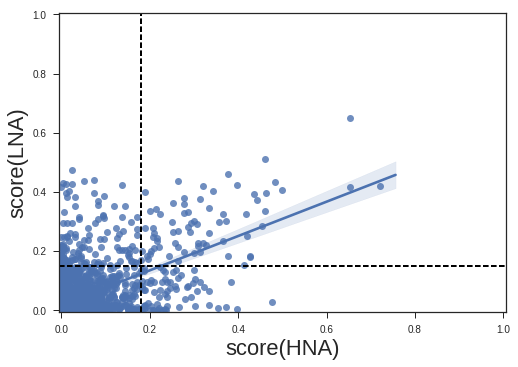

In [33]:
plt.figure()
sns.regplot(x=otu_scores.loc[:,'score'],y=otu_scores_lna.loc[otu_scores.index,'score'])
plt.axis([-0.005,1.005,-0.005,1.005])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('score(LNA)', size=22)
plt.yticks(size=10)
plt.axhline(y=thr, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr_lna, linewidth=2, linestyle='--', color = 'k')
plt.show()

This figure shows 4 area's: 
- (left top corner): OTU's selected solely in function of **LNA**-dynamics, 
- (right top corner): OTU's selected in function of both **HNA**- and **LNA**-dynamics, 
- (left bottom corner): OTU's that are _not_ selected, 
- (right bottom corner): OTU's selected solely in function of **HNA**-dynamics. 

Univariate vs. Stability selection

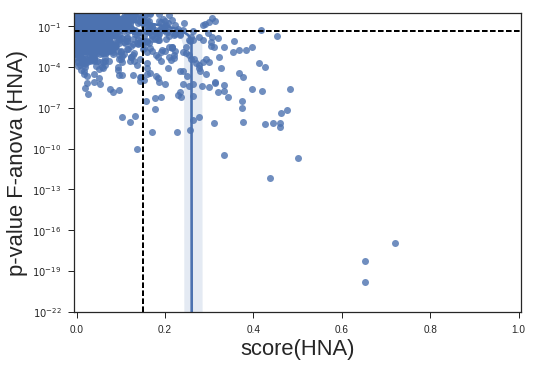

In [34]:
plt.figure()
sns.regplot(x=otu_scores.loc[:,'score'],y=uni_fs.loc[otu_scores.index,'p-value'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('p-value F-anova (HNA)', size=22)
plt.yticks(size=10)
plt.yscale('log')
plt.axhline(y=0.05, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr, linewidth=2, linestyle='--', color = 'k')
plt.axis([-0.005,1.005,0.0000000000000000000001, 1])
plt.show()

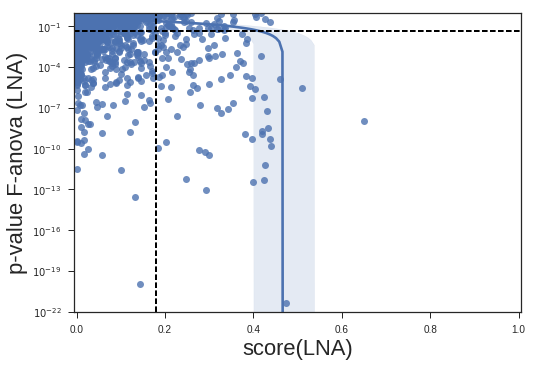

In [35]:
plt.figure()
sns.regplot(x=otu_scores_lna.loc[:,'score'],y=uni_fs_lna.loc[otu_scores.index,'p-value'])
plt.xlabel('score(LNA)', size=22)
plt.xticks(size=10)
plt.ylabel('p-value F-anova (LNA)', size=22)
plt.yticks(size=10)
plt.yscale('log')
plt.axhline(y=0.05, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr_lna, linewidth=2, linestyle='--', color = 'k')
plt.axis([-0.005,1.005,0.0000000000000000000001, 1])
plt.show()

This analysis shows that the HNA/LNA dynamics cannot solely be attributed to OTU's that are present in the respective cloud; this is also clear from the mutual correlation between HNA- and LNA-counts ( $\rho(\text{HNA,LNA}) = 0.75$ ). 

I see two reasons for this: 
- Some OTU's are simply present in the two clouds; 
- Some HNA-OTU's interact with LNA-OTU's and vice versa. 